# XGBoost Regressor Hyperparameter Optimization

This notebook demonstrates how to optimize XGBoost regressor hyperparameters using the following:
- TimeSeriesSplit with 5 folds for cross-validation
- Optuna for hyperparameter optimization
- The tabularaml library's cv.py function for evaluation
- Optimization metric: exp(-RMSE/100)

The goal is to create a submission file with columns 'id' and 'pollution_value' containing our predictions.

## 1. Import Required Libraries

In [1]:
!pip install -U -q numpy pandas optuna "xgboost>=1.7.0" scikit-learn category_encoders matplotlib seaborn cloudpickle optuna-integration[xgboost]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')


# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load and Explore Data

Let's load the training and test datasets. We'll assume the files are in the working directory.

In [3]:
import pandas as pd
import os, re
from tabularaml.generate.features import FeatureGenerator
import numpy as np

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_format = pd.read_csv('submission_example.csv')

########################################################################################


# Assume a dummy year since it's not provided
year = 2023
# Construct datetime from day_of_year and hour
train_df['datetime'] = pd.to_datetime(train_df['day_of_year'], format='%j', errors='coerce') \
                       + pd.to_timedelta(train_df['hour'], unit='h')
train_df['datetime'] = train_df['datetime'].apply(
    lambda dt: dt.replace(year=year) if pd.notnull(dt) else dt
)
# Sort by datetime column
train_df = train_df.sort_values(by='datetime')
# Drop the temporary datetime column
train_df = train_df.drop(columns='datetime')
# Reset the index
train_df.reset_index(inplace=True, drop=True)


#########################################################################################
X_train = train_df.drop([
    "id",
    "pollution_value"], axis=1).copy()
X_train_before = X_train.copy()
X_test = test_df.copy()

DIR = "model_redone"

# if os.path.isdir(DIR):
#     for f in sorted(
#         (f for f in os.listdir(DIR) if re.match(r"feature_generator_\d+\.pkl", f)),
#         key=lambda x: int(re.search(r"\d+", x).group())
#     ):
#         try:
#             gen = FeatureGenerator.load(f"{DIR}/{f}")
#             X_train = gen.fit_transform(X_train)
#             X_test = gen.transform(X_test)
#             print(f"Loaded and transformed with {f} successfully.")
#         except Exception as e:
#             print(f"Skipped {f}: {e}")

y_train = train_df["pollution_value"].copy()

## 3. Prepare Features and Target

Let's prepare the features and target variable for model training.

In [4]:
test_ids = test_df['id'].copy() 
# test_ids = test_data['id']

print(f"Training features shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Check for missing values
print("\nMissing values in training features:")
print(X_train.isnull().sum())

print("\nMissing values in target:")
print(y_train.isnull().sum())

print("\nMissing values in test features:")
print(X_test.isnull().sum())

Training features shape: (7649, 6)
Target shape: (7649,)
Test features shape: (2739, 7)

Missing values in training features:
latitude       13
longitude      13
day_of_year     0
day_of_week     0
hour            0
month           0
dtype: int64

Missing values in target:
0

Missing values in test features:
id             0
latitude       0
longitude      0
day_of_year    0
day_of_week    0
hour           0
month          0
dtype: int64


## 4. Set Up TimeSeriesSplit Cross-Validation

For time series data, we need to use a time-based validation approach. We'll use `TimeSeriesSplit` from scikit-learn with 5 folds.

In [5]:
from sklearn.model_selection import BaseCrossValidator
import numpy as np

class FixedWindowTimeSeriesSplit(BaseCrossValidator):
    """
    Custom time-series cross-validator with fixed-size test windows.
    Ensures every fold has meaningful training data and proper temporal ordering.
    
    Parameters
    ----------
    n_splits : int
        Number of folds. Must be at least 1.
    test_size : int
        Number of samples in each test fold.
    gap : int, default=0
        Number of samples to exclude between train and test sets.
    min_train_size : int, default=None
        Minimum number of training samples required. If None, defaults to test_size.
    """
    
    def __init__(self, n_splits=5, test_size=2700, gap=0, min_train_size=None):
        if n_splits < 1:
            raise ValueError("n_splits must be at least 1.")
        if test_size < 1:
            raise ValueError("test_size must be at least 1.")
        if gap < 0:
            raise ValueError("gap must be non-negative.")
        
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap
        self.min_train_size = min_train_size or test_size
        
        if self.min_train_size < 1:
            raise ValueError("min_train_size must be at least 1.")
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        
        # Check if we have enough data for at least one split
        min_required = self.min_train_size + self.gap + self.test_size
        if min_required > n_samples:
            raise ValueError(
                f"Not enough samples. Need at least {min_required} samples "
                f"(min_train_size={self.min_train_size} + gap={self.gap} + test_size={self.test_size}), "
                f"but got {n_samples}."
            )
        
        indices = np.arange(n_samples)
        
        if self.n_splits == 1:
            # Single window: place test at the end, ensure minimum training size
            test_end = n_samples
            test_start = test_end - self.test_size
            train_end = test_start - self.gap
            
            # Ensure we have minimum training size
            if train_end < self.min_train_size:
                train_end = self.min_train_size
                test_start = train_end + self.gap
                test_end = test_start + self.test_size
                
                # Check if this fits within our data
                if test_end > n_samples:
                    raise ValueError(
                        f"Cannot fit single split with constraints. "
                        f"Need {self.min_train_size + self.gap + self.test_size} samples, got {n_samples}."
                    )
            
            train_idx = indices[:train_end]
            test_idx = indices[test_start:test_end]
            yield train_idx, test_idx
            return
        
        # For multiple splits, distribute test windows
        # Last test window ends at n_samples, work backwards
        test_windows = []
        
        # Calculate positions for test windows
        # We want to distribute them evenly in the available space
        latest_test_end = n_samples
        earliest_test_start = self.min_train_size + self.gap
        
        # Available space for test window starts
        available_space = latest_test_end - self.test_size - earliest_test_start
        
        if available_space < 0:
            raise ValueError(
                "Cannot create requested splits. Try reducing n_splits, test_size, or min_train_size."
            )
        
        # Calculate step size between test windows
        if self.n_splits == 1:
            step = 0
        else:
            step = available_space / (self.n_splits - 1)
        
        # Generate test windows from last to first
        for i in range(self.n_splits):
            # Calculate test window position
            test_start = int(earliest_test_start + i * step)
            test_end = test_start + self.test_size
            
            # Ensure test window doesn't exceed data bounds
            if test_end > n_samples:
                test_end = n_samples
                test_start = test_end - self.test_size
            
            # Calculate training end (before gap)
            train_end = test_start - self.gap
            
            # Ensure minimum training size
            if train_end < self.min_train_size:
                raise ValueError(
                    f"Split {i+1} would have insufficient training data. "
                    f"Try reducing n_splits or min_train_size."
                )
            
            train_idx = indices[:train_end]
            test_idx = indices[test_start:test_end]
            
            yield train_idx, test_idx

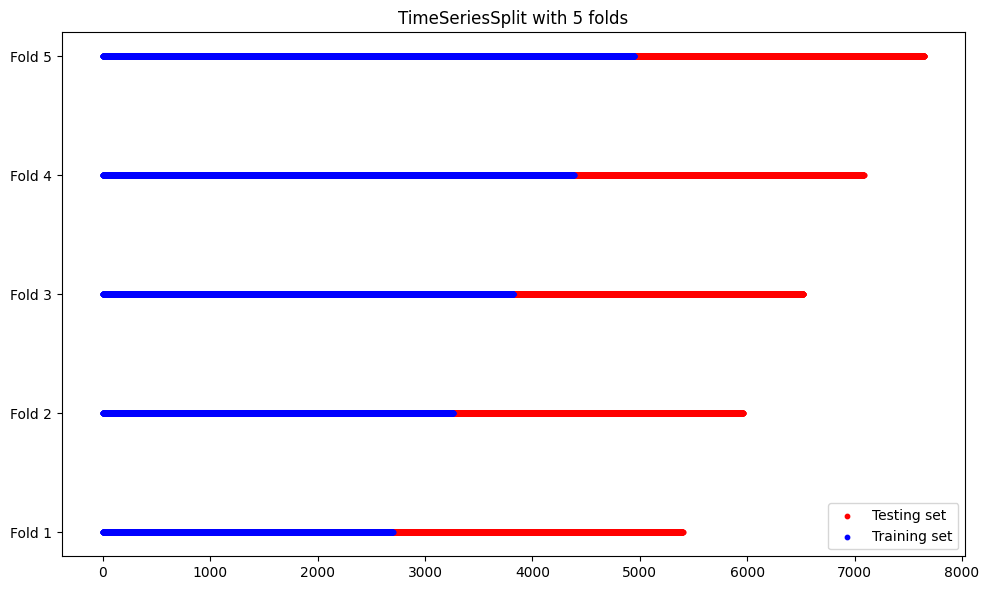

In [6]:
tss = FixedWindowTimeSeriesSplit(n_splits=5, test_size=2700)


# Visualize the TimeSeriesSplit
plt.figure(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tss.split(X_train)):
    plt.scatter(test_index, [i+0.5]*len(test_index), 
                c='red', s=10, label='Testing set' if i == 0 else "")
    plt.scatter(train_index, [i+0.5]*len(train_index), 
                c='blue', s=10, label='Training set' if i == 0 else "")

plt.yticks(np.arange(5) + 0.5, [f'Fold {i+1}' for i in range(5)])
plt.title('TimeSeriesSplit with 5 folds')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
for i, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train), 1):
    train_months = X_train.iloc[train_idx]["month"].value_counts().sort_index()
    val_months = X_train.iloc[val_idx]["month"].value_counts().sort_index()
    
    print(f"\n🔁 Fold {i}")
    print(f"  - Train size: {len(train_idx)}, Val size: {len(val_idx)}")
    print("  - Train months:\n", train_months.to_string())
    print("  - Val months:\n", val_months.to_string())


🔁 Fold 1
  - Train size: 2700, Val size: 2700
  - Train months:
 month
1      334
2      155
3      191
4      245
5     1613
12     162
  - Val months:
 month
5     162
6     208
7     372
8    1958

🔁 Fold 2
  - Train size: 3262, Val size: 2700
  - Train months:
 month
1      334
2      155
3      191
4      245
5     1775
6      208
7      192
12     162
  - Val months:
 month
7     180
8    1961
9     559

🔁 Fold 3
  - Train size: 3824, Val size: 2700
  - Train months:
 month
1      334
2      155
3      191
4      245
5     1775
6      208
7      372
8      382
12     162
  - Val months:
 month
8    1579
9    1121

🔁 Fold 4
  - Train size: 4386, Val size: 2700
  - Train months:
 month
1      334
2      155
3      191
4      245
5     1775
6      208
7      372
8      944
12     162
  - Val months:
 month
8     1017
9     1273
10     410

🔁 Fold 5
  - Train size: 4949, Val size: 2700
  - Train months:
 month
1      334
2      155
3      191
4      245
5     1775
6      208
7      

## 5. Define Optuna Objective Function for XGBoost GBRegressor

Now, we'll define the Optuna objective function to optimize XGBoost hyperparameters using our custom metric and TimeSeriesSplit cross-validation.

In [8]:
import xgboost as xgb
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('.'))
from spatio_temporal import AdvancedSpatioTemporalFeatures, SpatioTemporalDistributionAnalyzer
from sklearn.metrics import mean_squared_error

def objective(trial):
    """
    Optuna objective function to optimize XGBoost hyperparameters with AdvancedSpatioTemporalFeatures
    """
    # Define the hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 20),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_leaves': trial.suggest_int('max_leaves', 0, 1000),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_bin': trial.suggest_int('max_bin', 32, 512),
        'objective': 'reg:squarederror',
        'enable_categorical': True,
        'random_state': RANDOM_STATE,
        'n_jobs': -1  # Use all CPU cores
    }
    
    # AdvancedSpatioTemporalFeatures hyperparameters
    n_spatial_clusters = trial.suggest_int('n_spatial_clusters', 15, 35)
    n_temporal_clusters = trial.suggest_int('n_temporal_clusters', 8, 18)
    
    # Use predefined splitter for cross-validation
    folds = tss
    
    # Calculate test distribution stats using the analyzer from spatio_temporal.py
    temporal_stats = get_test_distribution_stats()
    
    # Use existing X_train and y_train
    X_base = X_train.copy()
    y = y_train.copy()
    
    # Apply log transformation to the target variable
    y = np.log1p(y)
    
    fold_scores = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_base, y)):
        # Split base features
        X_train_fold = X_base.iloc[train_idx].copy()
        X_valid_fold = X_base.iloc[valid_idx].copy()
        X_test_fold = X_test.copy()
        y_train_fold = y.iloc[train_idx]
        y_valid_fold = y.iloc[valid_idx]

        # Apply AdvancedSpatioTemporalFeatures with optimized parameters
        fe = AdvancedSpatioTemporalFeatures(
            row_only=False,  # Use clustering features inside CV
            n_spatial_clusters=n_spatial_clusters,
            n_temporal_clusters=n_temporal_clusters,
            january_bridge_features=True,  # Use January focus per user request
            test_distribution=temporal_stats,
            use_distribution_matching=True  # Use distribution matching features
        )
        
        # Apply feature engineering
        X_train_enhanced = fe.fit_transform(X_train_fold, y_train_fold)
        X_valid_enhanced = fe.transform(X_valid_fold)
        X_test_enhanced = fe.transform(X_test_fold)  # Keep for consistency
        
        # Train model on this fold
        model = xgb.XGBRegressor(**params)
        model.fit(X_train_enhanced, y_train_fold)
        
        # Predict on validation set
        y_pred_fold = model.predict(X_valid_enhanced)
        
        # Inverse transform predictions and actual values to calculate RMSE on original scale
        y_pred_orig_scale = np.expm1(y_pred_fold)
        y_valid_orig_scale = np.expm1(y_valid_fold)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_valid_orig_scale, y_pred_orig_scale))
        
        # Convert to exponential score format
        exp_score = np.exp(-rmse / 100)
        fold_scores.append(exp_score)
    
    # Return the mean validation score to maximize
    return np.mean(fold_scores)


def get_test_distribution_stats():
    """Get test distribution stats using SpatioTemporalDistributionAnalyzer"""
    # Create dummy DataFrames with required columns for the analyzer
    train_df_for_analysis = train_df.copy()
    test_df_for_analysis = test_df.copy()
    
    # Run the analyzer
    analyzer = SpatioTemporalDistributionAnalyzer()
    spatial_stats, temporal_stats = analyzer.analyze(train_df_for_analysis, test_df_for_analysis, verbose=False)
    
    return temporal_stats

## 6. Run Optuna Optimization

Now we'll run the optimization process to find the best hyperparameters.

In [ ]:
# ──────────────────── 4. Sampler & pruner ───────────────────────────────────
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

sampler = TPESampler(
    multivariate=True,
    group=True,
    n_startup_trials=20,
    constant_liar=True,   # set False if running strictly single-threaded
    seed=RANDOM_STATE,
)

pruner = HyperbandPruner(
    min_resource=1,       # first boosting round
    max_resource=1000,    # must match the upper bound of n_estimators
    reduction_factor=3,
)

# ──────────────────── 5. Create / resume study ──────────────────────────────
study = optuna.create_study(
    direction="maximize",
    study_name="xgboost_optimization",
    sampler=sampler,
    pruner=pruner,
    storage="sqlite:///xgb_optuna.db",  # makes the study persistent
    load_if_exists=True,               # resume if the DB already exists
)

# ──────────────────── 6. Optimise ───────────────────────────────────────────
N_TRIALS = 500
print(f"🔍  Running {N_TRIALS} trials …")
study.optimize(objective, n_trials=N_TRIALS)

# ──────────────────── 7. Results ────────────────────────────────────────────
best = study.best_trial
print("\n🎯  Best trial")
print(f"    exp(-RMSE/100) : {best.value:.4f}")
for k, v in best.params.items():
    print(f"    {k:<18}: {v}")

[I 2025-07-15 03:44:26,268] A new study created in RDB with name: xgboost_optimization


🔍  Running 500 trials …


In [ ]:
best = study.best_trial
print("\n🎯  Best trial")
print(f"    exp(-RMSE/100) : {best.value:.4f}")
for k, v in best.params.items():
    print(f"    {k:<18}: {v}")

In [ ]:
# Visualize the optimization process
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

plt.figure(figsize=(12, 8))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Hyperparameter Importances')
plt.tight_layout()
plt.show()

In [ ]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.metrics import mean_squared_error
# import optuna

# # Assume the following variables already exist from your setup before Optuna:
# # X_train: pd.DataFrame with features, including the original 'month' column
# # y_train: pd.Series with the target 'pollution_value'
# # create_cyclical_features: The function you defined
# # RANDOM_STATE: The integer seed you used

# # ---------------------------------------------------------------------------
# # 1. LOAD THE COMPLETED STUDY AND GET THE BEST PARAMETERS
# # ---------------------------------------------------------------------------
# print("\n" + "="*50)
# print("🚀  Starting Final Sanity Check on the 'Golden' January Fold")
# print("="*50)

# try:
#     # Load the study from the database
#     study = optuna.load_study(
#         study_name="xgboost_optimization",
#         storage="sqlite:///xgb_optuna.db"
#     )
#     best_params = study.best_params.copy() # Use .copy() to avoid modifying the original
#     print("✅ Successfully loaded best parameters from Optuna study.")
    
# except Exception as e:
#     print(f"❌ Could not load study due to: {e}. Please ensure the study exists.")
#     # In a real run, you might want to exit here or use default parameters
#     # For this example, we'll stop if the study isn't found.
#     exit()

# # Separate the model hyperparameters from our custom preprocessing hyperparameter
# n_clusters_best = best_params.pop('n_clusters')
# xgb_best_params = best_params

# # Add back the fixed XGBoost parameters needed for instantiation
# xgb_best_params.update({
#     'objective': 'reg:squarederror',
#     'enable_categorical': True,
#     'random_state': RANDOM_STATE,
#     'n_jobs': -1
# })

# print("\n📋 Best Hyperparameters for Final Model:")
# for k, v in xgb_best_params.items():
#     print(f"    {k:<18}: {v}")
# print(f"    {'n_clusters':<18}: {n_clusters_best}")


# # ---------------------------------------------------------------------------
# # 2. CREATE THE "GOLDEN" SPLIT FROM EXISTING X_train and y_train
# # ---------------------------------------------------------------------------
# # Create boolean masks based on the 'month' column in the existing X_train
# train_mask = X_train['month'] != 1
# val_mask = X_train['month'] == 1

# # Create the final training and validation sets using the masks
# X_train_final = X_train.loc[train_mask].copy()
# X_val_final = X_train.loc[val_mask].copy()

# y_train_final = y_train.loc[train_mask].copy()
# y_val_final = y_train.loc[val_mask].copy() # This is the true target for the golden fold

# print(f"\nGolden Split created from existing X_train:")
# print(f"  - Final Train size: {len(X_train_final)}")
# print(f"  - Final Validation size: {len(X_val_final)}")


# # ---------------------------------------------------------------------------
# # 3. APPLY THE IDENTICAL PREPROCESSING PIPELINE
# # ---------------------------------------------------------------------------
# print("\n🔧 Applying preprocessing pipeline...")

# # a) Cyclical Features
# # This function should drop the original time columns as it did in the objective
# X_train_final = create_cyclical_features(X_train_final)
# X_val_final = create_cyclical_features(X_val_final)

# # b) K-Means Clustering Feature
# if 'latitude' in X_train_final.columns and 'longitude' in X_train_final.columns:
#     print(f"  - Fitting KMeans with n_clusters={n_clusters_best}...")
#     kmeans = KMeans(n_clusters=n_clusters_best, random_state=RANDOM_STATE, n_init='auto')
    
#     # Impute NaNs temporarily just for clustering
#     lat_mean = X_train_final['latitude'].mean()
#     lon_mean = X_train_final['longitude'].mean()
#     train_coords_temp = X_train_final[['latitude', 'longitude']].fillna({'latitude': lat_mean, 'longitude': lon_mean})
#     valid_coords_temp = X_val_final[['latitude', 'longitude']].fillna({'latitude': lat_mean, 'longitude': lon_mean})
    
#     kmeans.fit(train_coords_temp)
    
#     X_train_final['cluster'] = kmeans.predict(train_coords_temp)
#     X_val_final['cluster'] = kmeans.predict(valid_coords_temp)
#     print("  - Cluster feature added.")

# # c) Log-transform the target for training
# y_train_log = np.log1p(y_train_final)

# # d) Align columns to ensure consistency
# common_features = list(X_train_final.columns.intersection(X_val_final.columns))
# X_train_final = X_train_final[common_features]
# X_val_final = X_val_final[common_features]


# # ---------------------------------------------------------------------------
# # 4. TRAIN THE FINAL MODEL AND EVALUATE
# # ---------------------------------------------------------------------------
# print("\n🧠 Training final model with best parameters...")
# final_model = xgb.XGBRegressor(**xgb_best_params)

# final_model.fit(X_train_final, y_train_log)

# print("📈 Predicting on the January validation set...")
# y_pred_log = final_model.predict(X_val_final)

# # Inverse transform predictions to get them back to the original scale
# y_pred_orig_scale = np.expm1(y_pred_log)

# # Calculate the final, reliable RMSE on the original scale validation target
# final_rmse = np.sqrt(mean_squared_error(y_val_final, y_pred_orig_scale))
# final_exp_score = np.exp(-final_rmse / 100)

# print("\n" + "="*50)
# print("🏆 FINAL PERFORMANCE ESTIMATE 🏆")
# print("="*50)
# print(f"  RMSE on 'Golden' January Fold: {final_rmse:.4f}")
# print(f"  Competition Score exp(-RMSE/100): {final_exp_score:.4f}")
# print("="*50)
# print("\nThis RMSE is your most reliable estimate for the private leaderboard.")

## 7. Train Final Model with Best Parameters

Using the best parameters found by Optuna, we'll train the final model on the full training data.

In [ ]:
# # Get the best parameters
# best_params = study.best_params

# # Add fixed parameters
# best_params['objective'] = 'reg:squarederror'
# best_params['random_state'] = RANDOM_STATE
# best_params['n_jobs'] = -1

# # Create and train the final model with the best parameters
# final_model = xgb.XGBRegressor(**best_params)

# print("Training final model with best parameters...")
# final_model.fit(X_train, y_train)

# # Evaluate on the training data
# train_preds = final_model.predict(X_train)
# train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
# train_metric = np.exp(-train_rmse/100)

# print(f"Final model training RMSE: {train_rmse:.4f}")
# print(f"Final model training metric (exp(-RMSE/100)): {train_metric:.4f}")

# # Feature importance
# plt.figure(figsize=(12, 6))
# xgb.plot_importance(final_model, max_num_features=10, height=0.8)
# plt.title('XGBoost Feature Importance')
# plt.tight_layout()
# plt.show()

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('.'))
from spatio_temporal import AdvancedSpatioTemporalFeatures, SpatioTemporalDistributionAnalyzer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
import gc

# --- Constants and helper functions ---
RANDOM_STATE = 42

def competition_score(y_true, y_pred):
    """Calculates the competition score: exp(-RMSE/100)"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return np.exp(-rmse / 100)

def get_test_distribution_stats():
    """Get test distribution stats using SpatioTemporalDistributionAnalyzer"""
    # Create DataFrames with required columns for the analyzer
    train_df_for_analysis = train_df.copy()
    test_df_for_analysis = test_df.copy()
    
    # Run the analyzer
    analyzer = SpatioTemporalDistributionAnalyzer()
    spatial_stats, temporal_stats = analyzer.analyze(train_df_for_analysis, test_df_for_analysis, verbose=False)
    
    return temporal_stats
# ----------------------------------------------------

# 1. LOAD DATA AND BEST PARAMETERS
# ----------------------------------------------------
print("\n" + "="*50)
print("🚀 Generating Final OOF Predictions with AdvancedSpatioTemporalFeatures")
print("="*50)

try:
    study = optuna.load_study(study_name="xgboost_optimization", storage="sqlite:///xgb_optuna.db")
    best_params = study.best_params.copy()
    print("✅ Successfully loaded best parameters from Optuna study.")
except Exception as e:
    print(f"❌ Could not load Optuna study, using placeholder params. Error: {e}")
    best_params = {'learning_rate': 0.05, 'n_estimators': 1500, 'max_depth': 10, 
                   'n_spatial_clusters': 25, 'n_temporal_clusters': 12} # Example

# Extract feature engineering parameters
n_spatial_clusters = best_params.pop('n_spatial_clusters', 25)
n_temporal_clusters = best_params.pop('n_temporal_clusters', 12)

# Prepare XGBoost parameters
xgb_best_params = best_params
xgb_best_params.update({
    'objective': 'reg:squarederror', 'enable_categorical': True, 
    'random_state': RANDOM_STATE, 'n_jobs': -1
})

# Calculate test distribution stats using the analyzer
temporal_stats = get_test_distribution_stats()
print("Best parameters loaded and test distribution calculated.")


# 2. SETUP THE OUT-OF-FOLD (OOF) PREDICTION PROCESS
# ----------------------------------------------------
N_SPLITS = tss.n_splits

# Initialize arrays and lists for storing predictions and scores
oof_preds = np.zeros(len(X_train))
test_preds_from_folds = []
fold_train_scores = []
fold_val_scores = []

print(f"\nStarting OOF prediction loop with {N_SPLITS} folds...")
print(f"Using n_spatial_clusters={n_spatial_clusters}, n_temporal_clusters={n_temporal_clusters}")


# 3. EXECUTE THE OOF LOOP WITH ADVANCED FEATURE ENGINEERING
# ----------------------------------------------------
for n_fold, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
    print(f"--- Processing Fold {n_fold + 1}/{N_SPLITS} ---")
    
    X_train_fold, X_val_fold = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    X_test_fold = X_test.copy()

    print("  - Applying AdvancedSpatioTemporalFeatures...")
    # Apply AdvancedSpatioTemporalFeatures with optimized parameters
    fe = AdvancedSpatioTemporalFeatures(
        row_only=False,  # Use clustering features inside CV
        n_spatial_clusters=n_spatial_clusters,
        n_temporal_clusters=n_temporal_clusters,
        january_bridge_features=True,  # Use January focus per user request
        test_distribution=temporal_stats,
        use_distribution_matching=True  # Use distribution matching features
    )
    
    # Apply feature engineering
    X_train_enhanced = fe.fit_transform(X_train_fold, y_train_fold)
    X_val_enhanced = fe.transform(X_val_fold)
    X_test_enhanced = fe.transform(X_test_fold)

    y_train_log = np.log1p(y_train_fold)
    
    print("  - Training model...")
    model = xgb.XGBRegressor(**xgb_best_params)
    model.fit(X_train_enhanced, y_train_log)
    
    # --- Calculate and log metrics in the competition format ---
    train_preds_log = model.predict(X_train_enhanced)
    val_preds_log = model.predict(X_val_enhanced)
    
    train_preds_orig = np.expm1(train_preds_log)
    val_preds_orig = np.expm1(val_preds_log)
    
    oof_preds[val_idx] = val_preds_orig # Store for overall OOF score
    
    train_comp_score = competition_score(y_train_fold, train_preds_orig)
    val_comp_score = competition_score(y_val_fold, val_preds_orig)
    
    fold_train_scores.append(train_comp_score)
    fold_val_scores.append(val_comp_score)
    
    print(f"  - Features: {X_train_enhanced.shape[1]} -> {X_val_enhanced.shape[1]}")
    print(f"  - Fold {n_fold + 1} Train Score: {train_comp_score:.4f} | Validation Score: {val_comp_score:.4f}")
    
    print("  - Predicting on test set...")
    test_preds_log = model.predict(X_test_enhanced)
    test_preds_from_folds.append(np.expm1(test_preds_log))
    
    del model, X_train_enhanced, X_val_enhanced, X_test_enhanced, y_train_fold, y_val_fold, fe
    gc.collect()

# 4. FINALIZE PREDICTIONS AND CREATE SUBMISSION FILE
# ----------------------------------------------------
print("\n" + "="*50)
print("📊 OOF Performance Summary with AdvancedSpatioTemporalFeatures")
print("="*50)

mean_train_score = np.mean(fold_train_scores)
std_train_score = np.std(fold_train_scores)
mean_val_score = np.mean(fold_val_scores)
std_val_score = np.std(fold_val_scores)

print(f"Average Train Competition Score across folds: {mean_train_score:.4f} (+/- {std_train_score:.4f})")
print(f"Average Validation Competition Score across folds: {mean_val_score:.4f} (+/- {std_val_score:.4f})")

# Calculate the overall OOF score on all combined validation predictions
overall_oof_score = competition_score(y_train, oof_preds)
print(f"\nOverall OOF Competition Score on combined validation sets: {overall_oof_score:.4f}")

# Average the predictions from all folds for a more robust test set prediction
final_test_preds = np.mean(test_preds_from_folds, axis=0)

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': test_df['id'], 'pollution_value': final_test_preds})
submission_df['pollution_value'] = submission_df['pollution_value'].clip(0)

# Save the submission file
submission_filename = f'submission_enhanced_astf_{overall_oof_score:.4f}.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"\n✅ Submission file '{submission_filename}' created successfully!")
print("Submission file head:")
print(submission_df.head())

## 8. Generate Predictions for Submission

Now let's generate predictions for the test data using our optimized model.

In [ ]:
# # Generate predictions for the test data
# print("Generating predictions for test data...")
# test_predictions = final_model.predict(X_test)

# # Display a sample of the predictions
# print("\nSample predictions:")
# pd.DataFrame({
#     'id': test_ids[:5],
#     'prediction': test_predictions[:5]
# })

## 9. Create Submission File

Finally, we'll create the submission file in the required format with 'id' and 'pollution_value' columns.

In [ ]:
# # Create the submission DataFrame with the required format
# submission = pd.DataFrame({
#     'id': test_ids,
#     'pollution_value': test_predictions
# })

# # Verify the submission format matches the required format
# print(f"Submission shape: {submission.shape}")
# print("Submission columns:", submission.columns.tolist())
# print("\nSubmission sample:")
# display(submission.head())

# # Save the submission file
# submission_file = 'xgboost_optimized_submission.csv'
# submission.to_csv(submission_file, index=False)
# print(f"\nSubmission saved to {submission_file}")

# # Calculate what the expected metric would be if RMSE was 10
# sample_metric = np.exp(-10/100)
# print(f"\nFor reference, if RMSE = 10, the metric value would be: {sample_metric:.4f}")
# print(f"Our best model achieved a metric value of: {trial.value:.4f} on validation")

## 10. Conclusion

In this notebook, we:

1. Loaded and explored the dataset
2. Prepared features and target variables
3. Set up TimeSeriesSplit cross-validation with 5 folds
4. Created a custom scoring metric to maximize exp(-RMSE/100)
5. Defined an extensive hyperparameter search space for XGBoost
6. Optimized the XGBoost model using Optuna
7. Trained a final model with the best parameters
8. Generated predictions and created a submission file

The final submission file contains the predicted pollution values for the test set in the required format.